# Continuum plots

Loads depth-frequency-time PSD data and then plots continuum for various analyses.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as pldates
from scipy.stats import chi2
from scipy.optimize import curve_fit
for i in range(2):
    %matplotlib notebook

In [314]:
# import data

adcp = 'Axis55'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2018

ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')
n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [315]:
# extract plotting variables & GM

t_stamp = int(ds[0].t_stamp)
depth = ds[0].depth.values
frequencies = ds[0].specf_c.values

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:,0]                                # GM based on N at -904 m
gm_psd = gm[:,1]

In [316]:
# select time range

# set date range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp_list,phi_u_temp,phi_v_temp = [],[],[]
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect_c.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_temp_list.append(ds[i].spect_c[j].values)
            phi_u_temp.append(ds[i].Sxxu_c[:,:,j])                 # time segment, [depth, freq]
            phi_v_temp.append(ds[i].Sxxv_c[:,:,j])
    dt_list.append(dt_temp_list)
    phi_u.append(phi_u_temp)
    phi_v.append(phi_v_temp)
print("Output time range:",dt_list[0][0],'to',dt_list[-1][-1])     # print to check desired interval

Output time range: 2018-01-11T16:07:30.000000000 to 2018-12-09T16:37:29.000000000


## Continuum fits (a, b)

In [166]:
# WKB scale and select depth

WKB_u,WKB_v = [],[]

for i in range(n_seg):
    WKB_u_test,WKB_v_test = [],[]
    for j in range(len(phi_u[i])):
        WKB_u_test.append(phi_u[i][j] / ds[0].WKB_scale)
        WKB_v_test.append(phi_v[i][j] / ds[0].WKB_scale)
    WKB_u.append(WKB_u_test)
    WKB_v.append(WKB_v_test)
    
didx = -1                   # -1 for lower depth, -20 for mid-depth
if adcp == 'Slope':
    didx = didx           # -1 for lower depth, -20 for mid-depth
elif adcp == 'Axis75':
    didx = didx           # -1 for lower depth, -19 for mid-depth
elif adcp == 'Axis55':
    didx = didx           # -1 for lower depth, -8 for mid-depth

u,v,time = [],[],[]
for i in range(n_seg):
    u_test,v_test,time_test = [],[],[]
    for j in range(len(phi_u[i])):
        u_test.append(WKB_u[i][j][didx,:].values)        
        v_test.append(WKB_v[i][j][didx,:].values)
        time_test.append(WKB_u[i][j].spect_c.values)
    u.append(u_test)
    v.append(v_test)
    time.append(time_test)
    
d_stamp = ds[0].depth[didx].values
print('Depth:',-d_stamp,'m')

Depth: -355 m


In [167]:
# continuum fits (7e-5 to 2e-4 Hz)

lowf = 130                    # set frequency range for continuum
highf = 370

f_range = frequencies[lowf:highf]      # set data range for continuum

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

ua,ub,va,vb = [],[],[],[]
u_c,v_c = [],[]

for i in range(n_seg):
    ua_temp,ub_temp,va_temp,vb_temp = [],[],[],[]
    u_range,v_range = [],[]
    for j in range(len(u[i])):
        u_range_temp = u[i][j][lowf:highf]
        v_range_temp = v[i][j][lowf:highf]

        # Fit the power-law data
        upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range_temp, p0=[1e-8, -2], bounds=([0,-5],[1,0]),maxfev=1000)
        vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range_temp, p0=[1e-8, -2], bounds=([1e-17,-5],[1e-3,0]),maxfev=1000)

        # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
        #ustdevs = np.sqrt(np.diag(ucov))
        #vstdevs = np.sqrt(np.diag(vcov))

        # Calculate the residuals
        #ures = u_range - power_law(f_range, *upars)
        #vres = v_range - power_law(f_range, *vpars)
        
        ua_temp.append(upars[0])       # get a and b coefficients
        ub_temp.append(upars[1])
        va_temp.append(vpars[0])
        vb_temp.append(vpars[1])
        u_range.append(u_range_temp)
        v_range.append(v_range_temp)
    
    ua.append(ua_temp)       # get a and b coefficients
    ub.append(ub_temp)
    va.append(va_temp)
    vb.append(vb_temp)
    u_c.append(u_range)
    v_c.append(v_range)

<IPython.core.display.Javascript object>


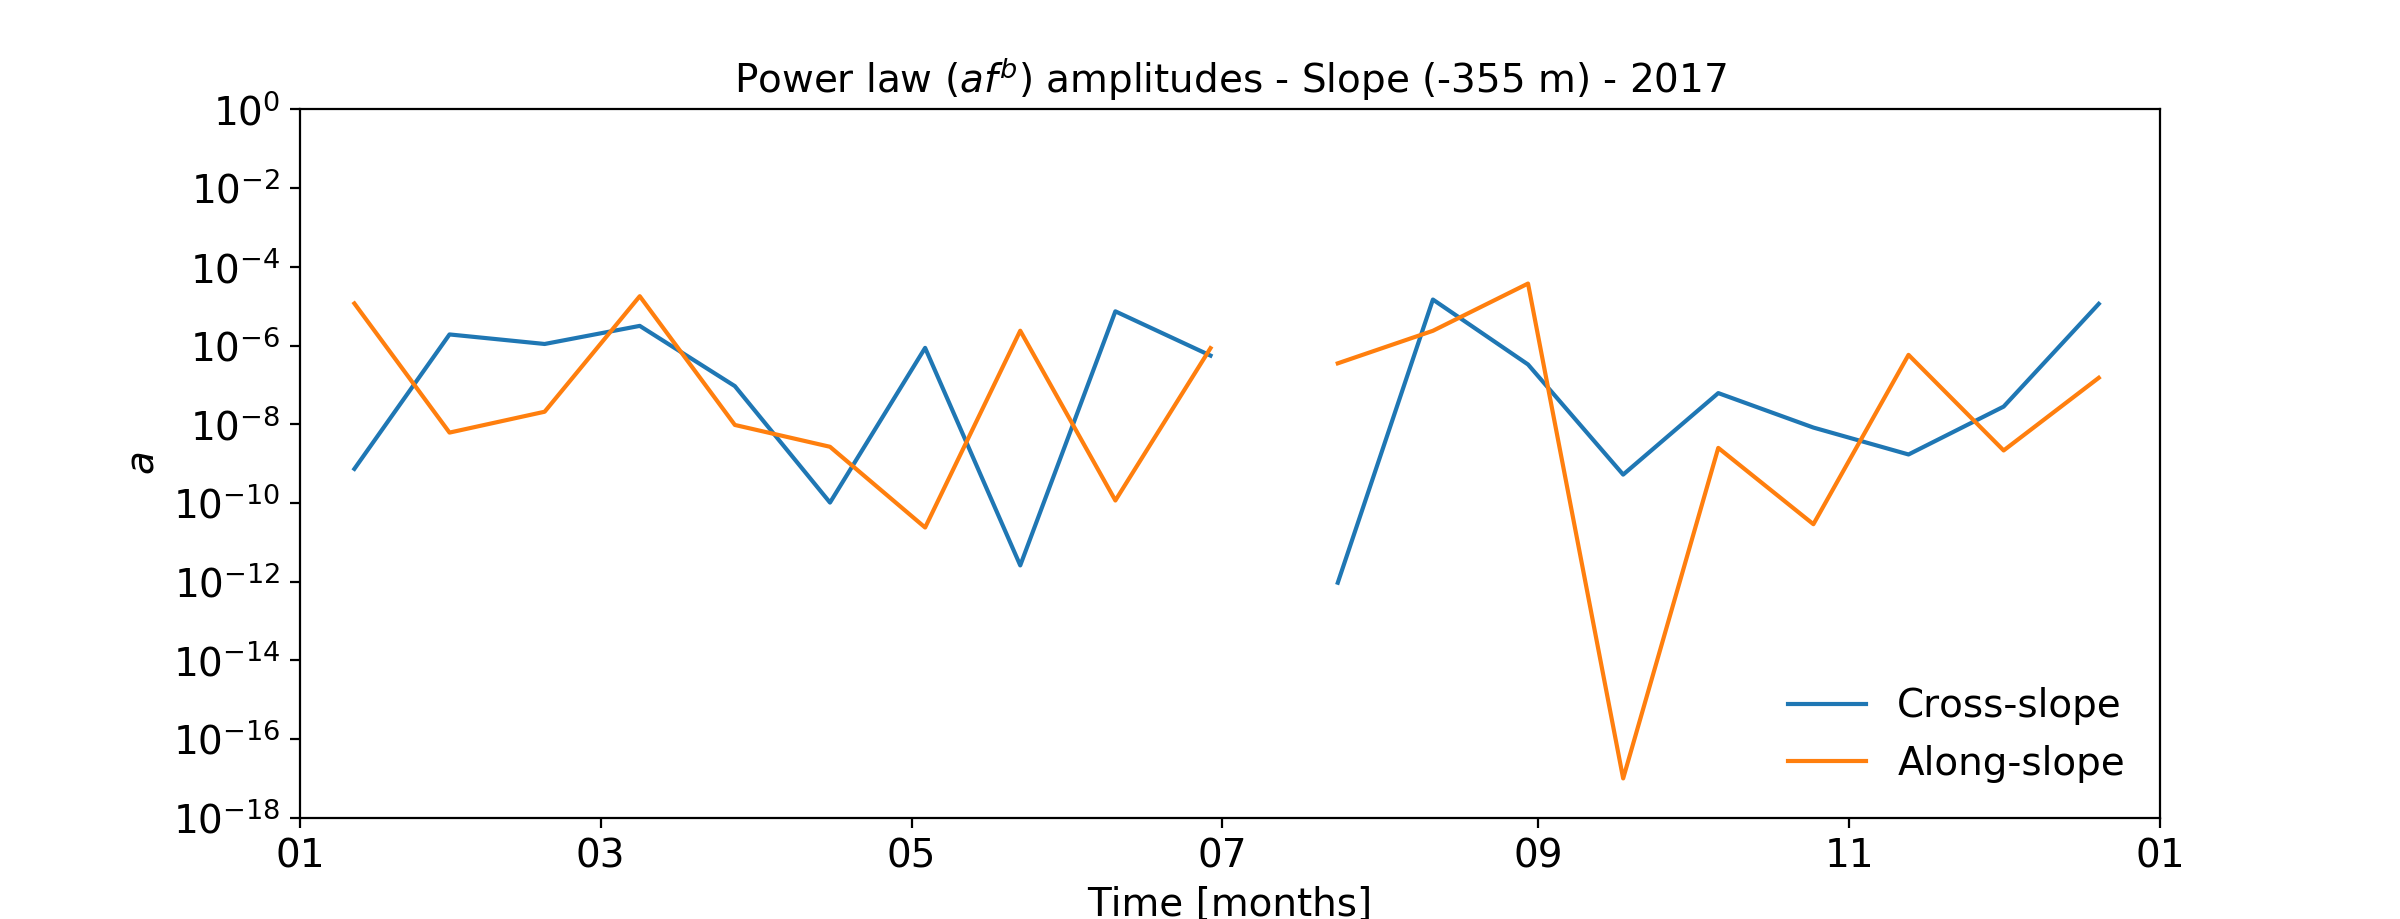

In [168]:
# plot a values

fig,ax = plt.subplots(1,1,figsize=(12,4.6))

ax.set_title(fr'Power law ($af^b$) amplitudes - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$a$',fontsize=14)  # (m/s)^2 ???
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            ax.plot(time[i],ua[i],label='Cross-slope',color='tab:blue')
            ax.plot(time[i],va[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],ua[i],label='Cross-canyon',color='tab:blue')
            ax.plot(time[i],va[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            ax.plot(time[i],ua[i],color='tab:blue')
            ax.plot(time[i],va[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],ua[i],color='tab:blue')
            ax.plot(time[i],va[i],color='tab:orange')

ax.set_yscale('log')
ax.set_xlim(start_date,end_date)
ax.set_ylim(1e-18,1e-0)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

plt.legend(fontsize=14,loc='lower right',frameon=False)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_a_{adcp}_{t_stamp}.pdf',format='pdf')

<IPython.core.display.Javascript object>


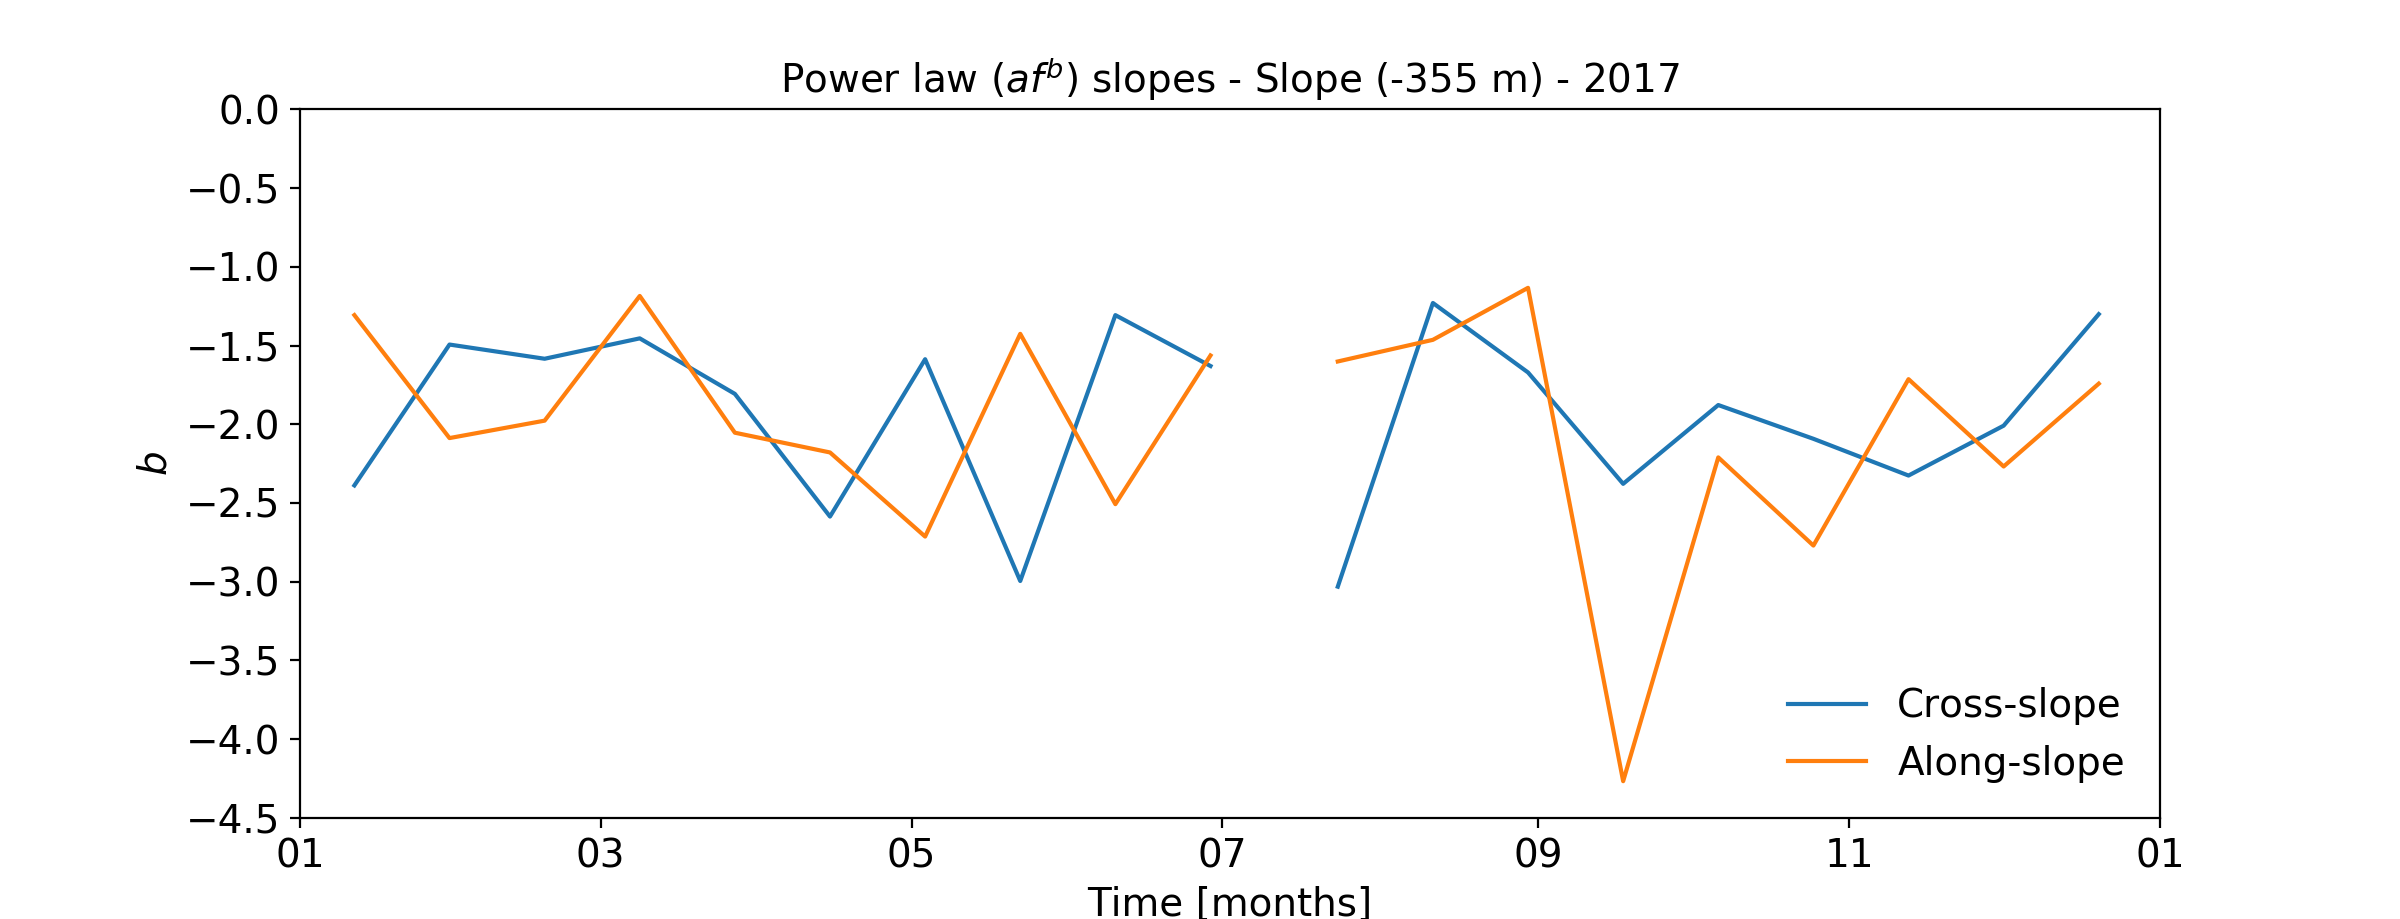

In [169]:
# plot b values

fig,ax = plt.subplots(1,1,figsize=(12,4.6))

ax.set_title(fr'Power law ($af^b$) slopes - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$b$',fontsize=14)
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            ax.plot(time[i],ub[i],label='Cross-slope',color='tab:blue')
            ax.plot(time[i],vb[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],ub[i],label='Cross-canyon',color='tab:blue')
            ax.plot(time[i],vb[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            ax.plot(time[i],ub[i],color='tab:blue')
            ax.plot(time[i],vb[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],ub[i],color='tab:blue')
            ax.plot(time[i],vb[i],color='tab:orange')
            
ax.set_xlim(start_date,end_date)
ax.set_ylim(-4.5,0)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

plt.legend(fontsize=14,loc='lower right',frameon=False)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_b_{adcp}_{t_stamp}.pdf',format='pdf')

## Get c amplitudes vs GM

In [317]:
# revise plotting variables

frequencies = ds[0].specf.values

In [318]:
# select time range

# set date range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp_list,phi_u_temp,phi_v_temp = [],[],[]
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_temp_list.append(ds[i].spect[j].values)
            phi_u_temp.append(ds[i].Sxxu[:,:,j])                 # time segment, [depth, freq]
            phi_v_temp.append(ds[i].Sxxv[:,:,j])
    dt_list.append(dt_temp_list)
    phi_u.append(phi_u_temp)
    phi_v.append(phi_v_temp)
print("Output time range:",dt_list[0][0],'to',dt_list[-1][-1])     # print to check desired interval

Output time range: 2018-01-06T08:07:30.000000000 to 2018-12-15T00:37:29.000000000


In [319]:
# WKB scale and select depth

WKB_u,WKB_v = [],[]

for i in range(n_seg):
    WKB_u_test,WKB_v_test = [],[]
    for j in range(len(phi_u[i])):
        WKB_u_test.append(phi_u[i][j] / ds[0].WKB_scale)
        WKB_v_test.append(phi_v[i][j] / ds[0].WKB_scale)
    WKB_u.append(WKB_u_test)
    WKB_v.append(WKB_v_test)
    
didx = -1                   # -1 for lower depth, -20 for mid-depth
if adcp == 'Slope':
    didx = didx           # -1 for lower depth, -20 for mid-depth
elif adcp == 'Axis75':
    didx = didx           # -1 for lower depth, -19 for mid-depth
elif adcp == 'Axis55':
    didx = didx           # -1 for lower depth, -8 for mid-depth

u,v,time = [],[],[]
for i in range(n_seg):
    u_test,v_test,time_test = [],[],[]
    for j in range(len(phi_u[i])):
        u_test.append(WKB_u[i][j][didx,:].values)        
        v_test.append(WKB_v[i][j][didx,:].values)
        time_test.append(WKB_u[i][j].spect.values)
    u.append(u_test)
    v.append(v_test)
    time.append(time_test)
    
d_stamp = ds[0].depth[didx].values
print('Depth:',-d_stamp,'m')

Depth: -933 m


In [320]:
# select continuum (7e-5 to 2e-4 Hz)

lowf = 130                    # set frequency range for continuum
highf = 370

f_range = frequencies[lowf:highf]      # set data range for continuum

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

u_cc,v_cc = [],[]

for i in range(n_seg):
    ua_temp,ub_temp,va_temp,vb_temp = [],[],[],[]
    u_range,v_range = [],[]
    for j in range(len(u[i])):
        u_range_temp = u[i][j][lowf:highf]
        v_range_temp = v[i][j][lowf:highf]
        u_range.append(u_range_temp)
        v_range.append(v_range_temp)
    u_cc.append(u_range)
    v_cc.append(v_range)

In [321]:
# whiten to find c

u_c_white,v_c_white,u_c_avg,v_c_avg = [],[],[],[]
for i in range(n_seg):
    u_c_white_temp,v_c_white_temp,u_c_avg_temp,v_c_avg_temp = [],[],[],[]
    for j in range(len(u_cc[i])):
        u_c_white_t = u_cc[i][j] * (f_range**2)
        u_c_white_temp.append(u_c_white_t)
        u_c_avg_temp.append(np.nanmean(u_c_white_t))
        v_c_white_t = v_cc[i][j] * (f_range**2)
        v_c_white_temp.append(v_c_white_t)
        v_c_avg_temp.append(np.nanmean(v_c_white_t))
    u_c_white.append(u_c_white_temp)
    v_c_white.append(v_c_white_temp)
    u_c_avg.append(u_c_avg_temp)
    v_c_avg.append(v_c_avg_temp)

In [322]:
# get GM comparison values

gmf = gm_freq / (2*np.pi) # in Hz
gmp = gm_psd * (np.pi)    # 1/2 GM for components
gmpw = gmp * (gmf**2)     # whiten
gmp_avg = np.nanmean(gmpw)# GM 'c' value

<IPython.core.display.Javascript object>


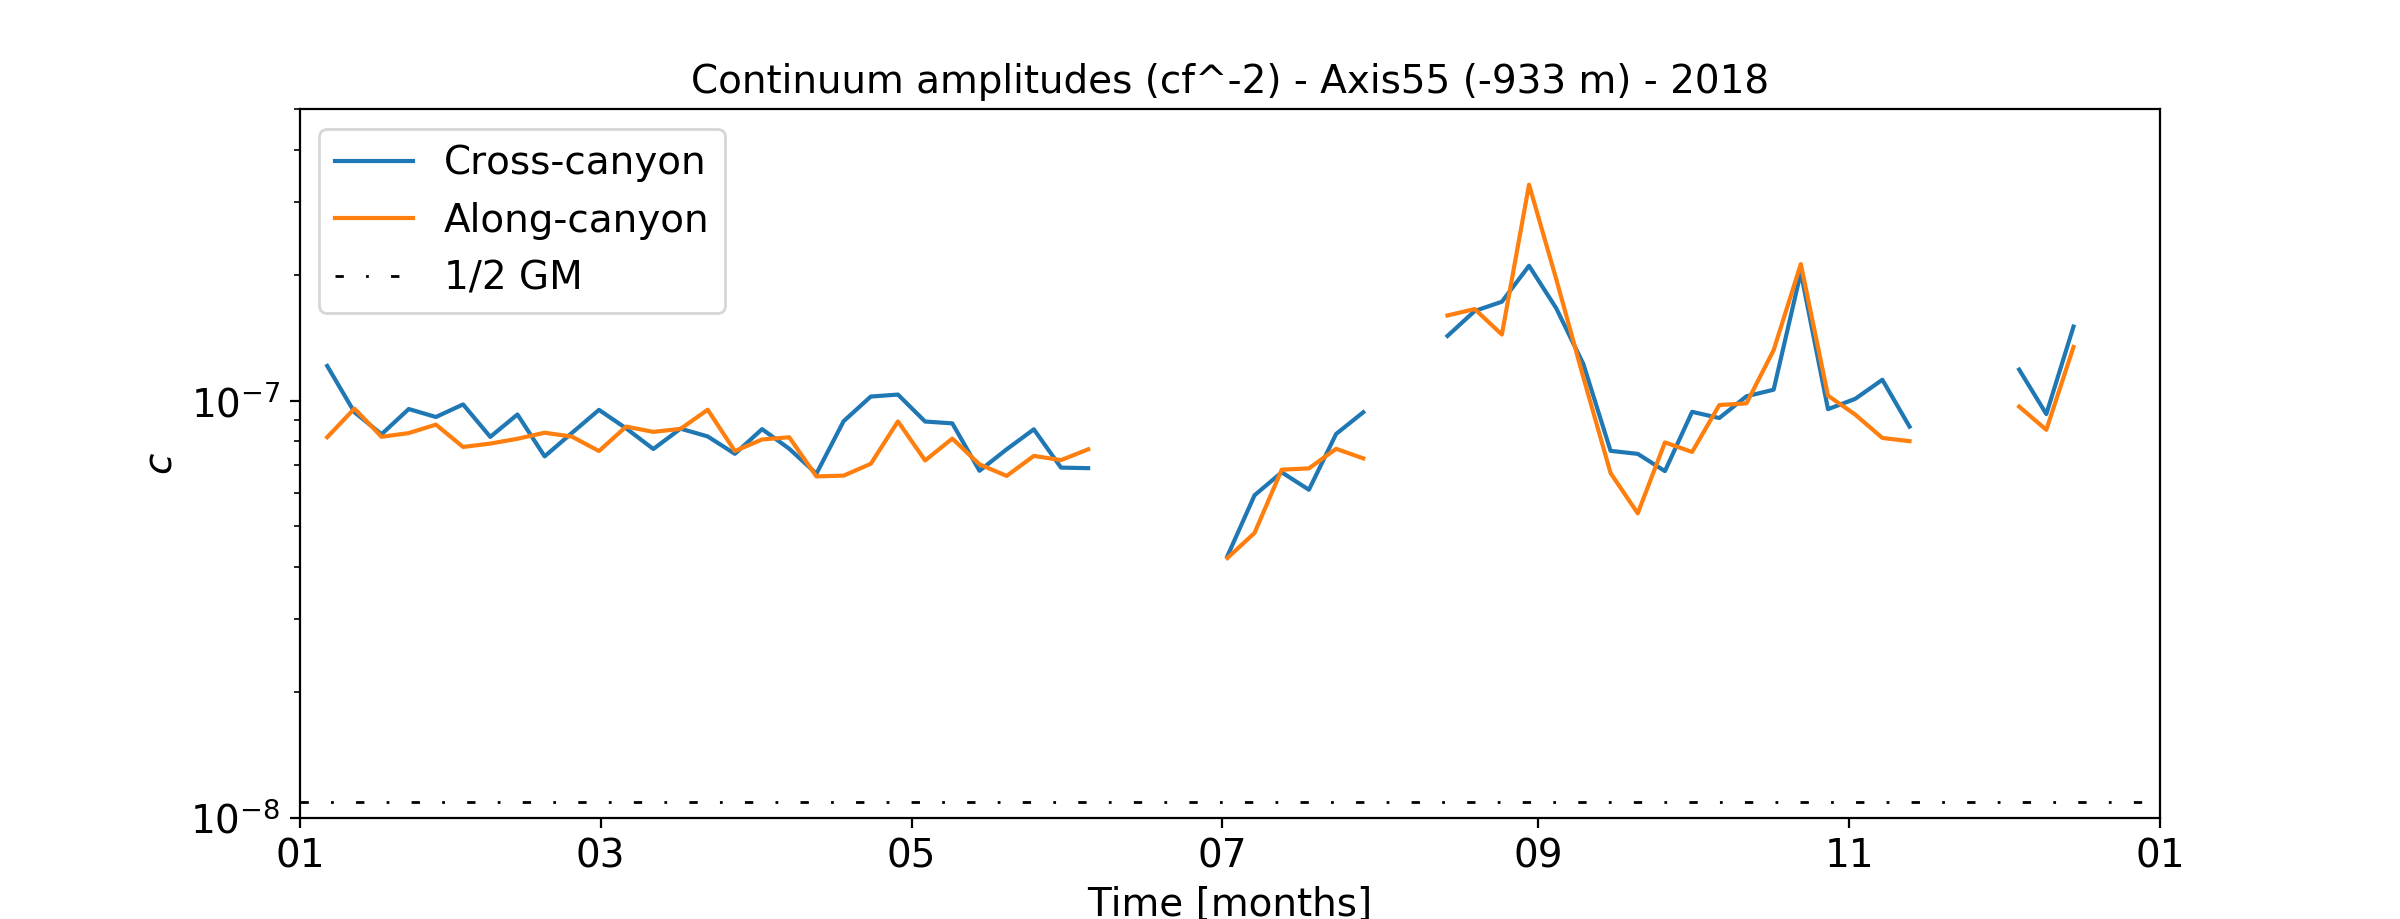

In [323]:
# plot c vs GM

fig,ax = plt.subplots(1,1,figsize=(12,4.6))

ax.set_title(fr'Continuum amplitudes (cf^-2) - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$c$',fontsize=14)
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            ax.plot(time[i],u_c_avg[i],label='Cross-slope',color='tab:blue')
            ax.plot(time[i],v_c_avg[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],u_c_avg[i],label='Cross-canyon',color='tab:blue')
            ax.plot(time[i],v_c_avg[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            ax.plot(time[i],u_c_avg[i],color='tab:blue')
            ax.plot(time[i],v_c_avg[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],u_c_avg[i],color='tab:blue')
            ax.plot(time[i],v_c_avg[i],color='tab:orange')
            
if adcp == 'Slope':
    ax.set_ylim(8e-9,8e-8)
elif adcp == 'Axis75':
    ax.set_ylim(8e-9,1e-7)
elif adcp == 'Axis55':
    ax.set_ylim(1e-8,5e-7)

ax.axhline(gmp_avg,color='black',ls=(0,(3,8,1,8)),lw=1,label='1/2 GM')
ax.set_yscale('log')
ax.set_xlim(start_date,end_date)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

plt.legend(fontsize=14,loc='best',frameon=True)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_c_{adcp}_{t_stamp}.pdf',format='pdf')